# Time Series Analysis for Stock Price Prediction

__Key Takeaways__:
By the end of this module, you will gain a comprehensive understanding of time series analysis techniques and their application in forecasting stock prices. You will be equipped with practical skills to build and evaluate time series models using real-world financial data.

## Libraries

In [ ]:
# !pip install yfinance

In [ ]:
# !pip install pandas_datareader

In [ ]:
# !pip install xgboost

In [136]:
# libraries
import pandas as pd
import numpy as np

# API to access stock data
import yfinance as yf
import pandas_datareader as pdr

from xgboost import XGBRegressor

# for time series modeling
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA 

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error # Evaluation
import matplotlib.pyplot as plt # Visualization
import plotly.express as px
from datetime import datetime, timedelta, date

# Supress warnings
import warnings
warnings.simplefilter(action="ignore", category=Warning)

### Import

In [19]:
symbol = 'AAPL'

In [64]:
# Date from Google Finance
stock_price = yf.download(symbol, start=start_date, end=end_date)
stock_price.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059441,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349136,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925629,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582657,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750244,132079200


### Explore

In [126]:
# Create prepare_data function
def prepare_data(symbol):

    # start_date = datetime.strptime('2019-04-1', '%Y-%m-%d')
    # end_date = datetime.strptime('2024-05-08', '%Y-%m-%d')

    today = date.today()

    start_date = (today - timedelta(days=365*5))#.strftime('%Y-%m-%d') # 5 years of data
    end_date = today#.strftime('%Y-%m-%d')

    # download
    data = yf.download(symbol, start=start_date, end=end_date)

    # filter Adj Close
    data = data[['Adj Close']]

    # Rename Adj Close
    data = data.rename(columns={'Adj Close': 'price'})

    # Moving Average 20, 50
    data['ma_50'] = data['price'].rolling(window=50).mean()
    data['ma_200'] = data['price'].rolling(window=200).mean()

    # Calculate returns
    data['daily_returns'] = data['price'].pct_change()*100

    # Drop NaN'set
    data.dropna(inplace=True)

    return data

$R_4 - returns$
$$R_t = (P_1 - P_0)/P_0$$

In [95]:
(72.349136 - 73.059441) / 73.059441*100

-0.9722289005742669

In [127]:
# Calling the function
df = prepare_data(symbol)
print(df.info())
df.head()

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1058 entries, 2020-02-25 to 2024-05-07
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          1058 non-null   float64
 1   ma_50          1058 non-null   float64
 2   ma_200         1058 non-null   float64
 3   daily_returns  1058 non-null   float64
dtypes: float64(4)
memory usage: 41.3 KB
None


,price,ma_50,ma_200,daily_returns
Date,,,,
2020-02-25,70.241074,74.497502,58.357456,-3.387246
2020-02-26,71.355370,74.603969,58.476038,1.586388
2020-02-27,66.690994,74.599198,58.585141,-6.536825
2020-02-28,66.651970,74.570731,58.690499,-0.058515
2020-03-02,72.857330,74.663697,58.824152,9.310093


In [128]:
# fil;tering by date index
plot_data = df.loc['2023-01-01':'2023-12-31']

In [129]:
# plot time series
plt.Figure(figsize=(10,25))

fig = px.line(
    data_frame=plot_data, 
    x=plot_data.index, 
    y=['price', 'ma_50', 'ma_200']
)

# Display plot
fig.show()

In [ ]:
# Plot

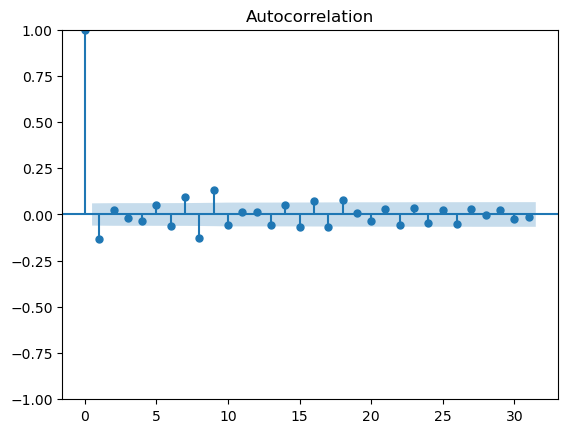

In [130]:
# Daily returns are stationary at lag 0
# That tells us about the parameter p
plot_acf(df.daily_returns);

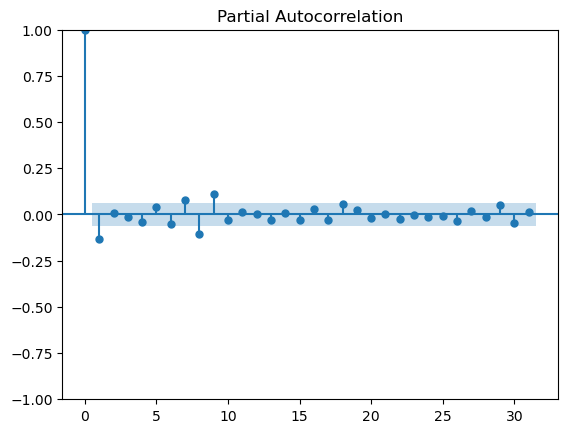

In [131]:
plot_pacf(df.daily_returns);

In [132]:
# Split the data into training and testing sets
cutoff = '2023-05-07'

df = df[['daily_returns']]
y_train = df.loc[:cutoff, :]
y_test = df.loc[cutoff:,:]

print(f'Train: {y_train.shape} Test: {y_test.shape}')

Train: (806, 1) Test: (252, 1)


### Split

In [ ]:
import datetime as dt
df['Date'].info()

In [ ]:
def create_features(df):
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    
    # Fourier features for capturing seasonality
    for k in range(1, 3):  # K=2 fourier pairs
        df[f'sin{k}'] = np.sin(df['dayofyear'] * (2. * np.pi * k / 365.25))
        df[f'cos{k}'] = np.cos(df['dayofyear'] * (2. * np.pi * k / 365.25))
    return df

train_features = create_features(train_data.copy())
test_features = create_features(test_data.copy())

In [ ]:
# Define the features and the target
feature_columns = ['dayofyear', 'dayofweek', 'month', 'sin1', 'cos1', 'sin2', 'cos2']
target_column = 'Price'

## Build Model

### Baseline

In [133]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mea_baseline = mean_absolute_error(y_train, y_pred_baseline)

print(f'MAE: {mea_baseline}')

MAE: 1.6290383990224442


### Iterate

In [141]:
# Model Pipeline
# p - AR
# q - MA
model = arch_model(y_train, p=1, q=0, rescale=False).fit()

# Summary of the model
model.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3413.8374974104127
Iteration:      2,   Func. Count:     13,   Neg. LLF: 4034.1381092193524
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1811.0349727238631
Iteration:      4,   Func. Count:     25,   Neg. LLF: 2756.3020762304523
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1774.1988075497975
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1774.1966391289368
Iteration:      7,   Func. Count:     39,   Neg. LLF: 1774.196596870588
Iteration:      8,   Func. Count:     43,   Neg. LLF: 1774.1965961656892
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1774.1965961656892
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:          daily_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1774.20
Distribution:                  Normal   AIC:                           3554.39
Method:            Maximum Likelihood   BIC:                           3568.47
                                        No. Observations:                  806
Date:                Wed, May 08 2024   Df Residuals:                      805
Time:                        11:16:51   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1819  7.690e-02      2.365  1.804e-02 [3.114e-02,  0.333]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          3.9503      0.381     10.355  3.971e-25   [  3.203,  4.698]
alpha[1]       0.2195  7.280e-02      3.015  2.574e-03 [7.677e-02,  0.362]
==========================================================================

Covariance estimator: robust
"""

In [ ]:
# Model Pipeline
# pipeline = Pipeline(steps=[
#     ('encoder', ColumnTransformer(
#         transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), ['dayofweek', 'month'])],
#         remainder='passthrough')),
#     ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror'))
# ])

# # Fit the model
# pipeline.fit(train_features[feature_columns], train_features[target_column])


### Evaluate

In [142]:
model.aic

3554.3931923313785

In [143]:
model.bic

3568.4694435588985

In [150]:
model.forecast(horizon=1, reindex=False).mean

,h.1
Date,
2023-05-05,0.181858


In [ ]:
# Predict using the model
# train_preds = pipeline.predict(train_features[feature_columns])
# test_preds = pipeline.predict(test_features[feature_columns])

In [ ]:
# Evaluate the model
# train_rmse = np.sqrt(mean_squared_error(train_features[target_column], train_preds))
# test_rmse = np.sqrt(mean_squared_error(test_features[target_column], test_preds))
# print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

In [ ]:
# Create future dates for forecasting
# future_dates = pd.date_range(start=test_data['Date'].max() + timedelta(days=12), periods=180, freq='D')
# future_data = pd.DataFrame({'Date': future_dates})
# future_features = create_features(future_data.copy())

## Communicate

In [ ]:
# Plot the results
# Use data visualization libraries to display the forecast results

In [ ]:
# FBprophet lib
# H2O.ai

In [ ]:
# Forecast future demand
# future_preds = pipeline.predict(future_features[feature_columns])

In [ ]:
# Plot the results
# plt.figure(figsize=(14, 7))
# plt.plot(train_data['Date'], train_data['Price'], label='Train Data')
# plt.plot(test_data['Date'], test_data['Price'], label='Test Data')
# plt.plot(future_dates, future_preds, label='Forecast', color='red')
# plt.legend()
# plt.title('Stock Price Prediction')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.show()


## Extract Stocks Data

In [ ]:
start_date = '2020-01-01'
end_date = '2023-12-31'
tickers = ['AAPL', 'GOOGL', 'MSFT', 'TSLA']

def extract_data(tickers, start=start_date, end=end_date):
    df = pd.DataFrame()
    for ticker in tickers:
        current_df = yf.download(ticker, start=start_date, end=end_date).assign(Symbol = ticker)
        df = pd.concat([df, current_df])
    
    df = df .reset_index()
    
    # Convert column names to lowercase
    df.columns = (
        df.columns
        .str.lower()
        .str.replace(' ', '_')
    )

    return df

# Test the function
df = extract_data(tickers, start=start_date, end=end_date)
df.head()

## Data Profiling

In [ ]:
df = pd.read_csv('./data/stocks.csv')
df.head()

In [ ]:
sk.skim(df)

## Visualize Data

In [ ]:
# plotly engine
df \
.groupby('symbol') \
.plot_timeseries(
    'date', 'adj_close',
    facet_ncol = 2,
    smooth = True,
    smooth_frac = 0.10,
    width = 900,
    height = 700,
    engine = 'plotly'
)

## Technical Indicators

### Trend Indicators:
 - __Moving Averages__ - helps smooth out price data to form a single flowing line, identifying the direction of the trend.

### Add 2 moving averages (20-day and 50-Day)

In [ ]:
sma_df = (
    df[['symbol', 'date', 'adj_close']] 
    .groupby('symbol') 
    .augment_rolling(
        date_column = 'date',
        value_column = 'adj_close',
        window = [20, 50],
        window_func = ['mean'],
        center = False
    )
)

sma_df.head()

In [ ]:
# Visualize 
(sma_df 

    # zoom in on dates to filter out `NaN`s
    .query('date >= "2023-06-01"') 

    # Convert to long format
    .melt(
        id_vars = ['symbol', 'date'],
        value_vars = ["adj_close", "adj_close_rolling_mean_win_20", "adj_close_rolling_mean_win_50"]
    ) 

    # Group on symbol and visualize
    .groupby("symbol") 
    .plot_timeseries(
        date_column = 'date',
        value_column = 'value',
        color_column = 'variable',
        smooth = False, 
        facet_ncol = 2,
        width = 900,
        height = 700,
        engine = "plotly"
    )
)

## Returns Analysis

In finance, returns analysis is like checking how well an investment did compared to how much money was put into it. It helps investors see how their investments are doing and decide if they're worth the risk:

- __Performance:__ Returns analysis tells us how well investments are doing and how much risk they carry.
- __Data-driven Decision Making:__ It helps investors and managers make smart choices about where to put their money, how to manage risk, and what investment strategies to follow.

In [ ]:
# Compute returns per each stock
returns_wide_df = (
    df[['symbol', 'date', 'adj_close']]
    .pivot(index = 'date', columns = 'symbol', values = 'adj_close')
    .pct_change()
    .reset_index()[1:]
)

returns_wide_df

In [ ]:
# Descriptive Statistics
returns_wide_df.describe(include='number')

In [ ]:
# Correlation
corr_df = (
    returns_wide_df
    .drop('date', axis=1)
    .corr()
)
corr_df

## 50-Day Rolling Regression
We need to make a regression function that returns the Slope and Intercept. 

### Get Market Returns
For our purposes, we assume the market is the average returns of the 6 technology stocks.
- We calculate an equal-weight portfolio as the `market returns`.
- Then we merge the market returns into the returns long data.

In [ ]:
# Let’s compute and visualize the 50-day rolling statistics.
returns_long_df = returns_wide_df \
    .melt(id_vars='date', value_name='returns') 

# returns_long_df
rolling_stats_df = (
    returns_long_df.groupby('symbol')
    .augment_rolling(
        date_column = 'date',
        value_column = 'returns',
        window = [50],
        window_func = [
            'mean', 
            'std', 
            'min', 
            ('Q25', lambda x: np.quantile(x,0.25)), 
            'median', 
            ('Q75', lambda x: np.quantile(x, 0.75)), 
            'max'
        ]
    ))

In [ ]:
# Finally, we can .melt() each of the rolling statistics for a Long Format Analysis
rolling_stats_long_df = (
    rolling_stats_df
    .melt(
        id_vars = ["symbol", "date"],
        var_name = "statistic_type"
    )
)

rolling_stats_long_df

In [ ]:
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetches stock data using yfinance API.

    Args:
    - ticker (str): Stock ticker symbol
    - start_date (str): Start date in 'YYYY-MM-DD' format
    - end_date (str): End date in 'YYYY-MM-DD' format

    Returns:
    - DataFrame: Stock price data
    """
    data = yf.download('BTC-USD', period='1y')
    return data

def create_database(data, db_name):
    """
    Creates an SQLite in-memory database and inserts data.

    Args:
    - data (DataFrame): Stock price data
    - db_name (str): Name of the SQLite in-memory database

    Returns:
    - None
    """
    sql_engine = create_engine(f"sqlite:///{db_name}", echo=False)
    data.to_sql(name='stock_prices', con=sql_engine, if_exists='replace')
    
def transform_to_returns(data):
    """
    Function to transform stock data into daily returns per symbol.
    """
    # Function to transform data into returns
    data['Returns'] = data['Adj Close'].pct_change()
    return data.dropna()

def fetch_data_from_database(db_name):
    """
    Fetches data from the SQLite in-memory database.

    Args:
    - db_name (str): Name of the SQLite in-memory database
    - start_date (str): Start date in 'YYYY-MM-DD' format
    - end_date (str): End date in 'YYYY-MM-DD' format

    Returns:
    - DataFrame: Stock price data
    """
    sql_engine = create_engine(f"sqlite:///{db_name}", echo=False)
    query = "SELECT * FROM stock_prices"
    data = pd.read_sql_query(query, sql_engine)
    
    # Manually set a range of dates as the index
    data.index = pd.date_range(start=start_date, periods=len(data), freq='D')
    
    data = transform_to_returns(data)
    
    return data

In [ ]:
start_date = '2020-01-01'
aapl_df = fetch_data_from_database('stock_data.db') #.info()

In [ ]:
df = aapl_df.reset_index(inplace=False)
df.rename(columns={'index': 'Date', 'Adj Close': 'price'}, inplace=True)
df.info()

In [ ]:
stocks_df = tk.load_dataset('stocks_daily', parse_dates=['date'])
stocks_df.glimpse()

In [ ]:
# Plot price series
stocks_df.groupby('symbol').plot_timeseries(
    date_column='date', 
    value_column='adjusted', 
    facet_ncol=3,
    engine='plotly'
)

In [ ]:
from sklearn.pipeline import make_pipeline

## 1. Introduction to Time Series Data
- Definition of Time Series Data
- ___Characteristics of Time Series Data:___ Trend, Seasonality, Cyclical Patterns, Random Noise
- Applications of Time Series Analysis in Finance, Economics, and Business

In [ ]:
# List of tech companies
tech_companies = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

In [ ]:
# Function to download stock data
def download_data(symbol):
    try:
        data = yf.download(symbol, start='2020-01-01', end='2024-01-01')
        return data
    except Exception as e:
        print(f"Error downloading data for {symbol}: {e}")
        return None

In [ ]:
def transform_to_returns(data):
    """
    Function to transform stock data into daily returns per symbol.
    """
    # Function to transform data into returns
    data['Returns'] = data['Adj Close'].pct_change()
    return data.dropna()

In [ ]:
# Function to load data into SQLite database
def load_data(symbol, data):
    """
    Function to load transformed data into an `tech_stocks.db` SQLite database.
    """
    conn = sqlite3.connect('tech_stocks.db')
    data.to_sql(name=symbol, con=conn, if_exists='replace', index=False)
    conn.close()

In [ ]:
# ETL process
def etl_process():
    for symbol in tech_companies:
        print(f"Downloading data for {symbol}...")
        stock_data = download_data(symbol)
        if stock_data is not None:
            print(f"Calculating returns for {symbol}...")
            returns_data = transform_to_returns(stock_data)
            print(f'>>>>>>>>>>>>>>>>DONE>>>>>>>>>>>>>>>')
            load_data(symbol, returns_data)
    
    print(f"{'='}"*30)
    print(f'ETL Process is Complete!')

In [ ]:
if __name__ == "__main__":
    etl_process()

In [ ]:
def get_table_names(db_name='tech_stocks.db'):
    """
    Function to retrieve table names from the SQLite database.
    Returns a list of table names.
    """
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()
    query = """
            SELECT name FROM sqlite_master WHERE type='table'
            """
    cursor.execute(query)
    table_names = [table[0] for table in cursor.fetchall()]
    conn.close()
    return table_names

In [ ]:
def fetch_from_database(symbol, db_name='tech_stocks.db'):
    """
    Function to fetch data for a specific stock symbol from SQLite database into a pandas dataframe.
    """
    conn = sqlite3.connect(db_name)
    query = f"SELECT * FROM {symbol}"
    df = pd.read_sql_query(query, conn, index_col='date')
    conn.close()
    return df

In [ ]:
get_table_names()

In [ ]:
fetch_from_database(get_table_names()[1])

In [ ]:
def main():
    # Download stock data
    print("Downloading stock data...")
    stock_data = download_stock_data(tech_companies)
    print("All stock data downloaded successfully.")
    
    # Convert data into dataframes
    for symbol, data in stock_data.items():
        stock_data[symbol] = pd.DataFrame(data)

    # Transform data into returns
    print("Transforming data into returns...")
    returns_data = transform_to_returns(stock_data)
    print("Data transformed successfully.")

    # Load data into database
    print("Loading data into database...")
    load_into_database(returns_data)
    print("Data loaded into database successfully.")
    
    # Fetch data for the specified symbol
    
    # Symbol to fetch data for
    symbol_to_fetch = 'AAPL'  # Example symbol

    print(f"Fetching data for {symbol_to_fetch} from database...")
    df = fetch_from_database(symbol_to_fetch)
    print("Data fetched successfully.")

    # Display the dataframe
    print("DataFrame for", symbol_to_fetch)
    print(df.head())  # Displaying first few rows of data

In [ ]:
if __name__ == "__main__":
    main()

## 2. Time Series Decomposition
- Understanding Trend, Seasonality, and Residual Components
- ___Decomposition Techniques:___ Additive Decomposition, Multiplicative Decomposition
- Implementing Decomposition Methods using Python libraries like statsmodels

## 3. Stationarity and Differencing
- ___Stationarity:___ Definition and Importance in Time Series Analysis
- Identifying Stationarity using Statistical Tests (e.g., Augmented Dickey-Fuller test)
- ___Techniques for Achieving Stationarity:___ Differencing, Transformation
- Implementing Stationarity Checks and Differencing in Python with pandas and numpy

## 4. Autoregressive Integrated Moving Average (ARIMA) Model
- ___Introduction to ARIMA Model and its Components:___ Autoregressive (AR), Integrated (I), Moving Average (MA)
- ___Understanding the Parameters of ARIMA Model:___ p, d, q
- ___Steps for Building an ARIMA Model:___ Model Identification, Parameter Estimation, Model Diagnostic Checking, Forecasting
- Implementing ARIMA Modeling in Python with statsmodels library

## 5. Model Evaluation Metrics
- ___Mean Absolute Percentage Error (MAPE):___ Interpretation and Calculation
- ___Root Mean Squared Error (RMSE):___ Interpretation and Calculation
- Comparison of Different Models based on Evaluation Metrics
- ___Hands-on Practice:___ Evaluating ARIMA Model Performance on Stock Price Data

## 6. Advanced Time Series Techniques (Optional)
- ___Seasonal ARIMA (SARIMA) Model:___ Incorporating Seasonal Components into ARIMA
- ___Exponential Smoothing Methods:___ Simple Exponential Smoothing (SES), Holt-Winters Exponential Smoothing
- ___Prophet:___ Facebook's Time Series Forecasting Tool
- Introduction to Deep Learning-based Time Series Forecasting Models (e.g., LSTM)

## 7. Applications in Stock Price Prediction
- Forecasting Stock Prices using ARIMA Model
- Interpreting Model Forecasts and Understanding Limitations
- Incorporating External Factors for Improved Forecasting Accuracy
- Real-world Case Studies and Examples of Time Series Analysis in Financial Markets

## 8. Project: Stock Price Prediction

___Hands-on Project:___ Building a Stock Price Prediction Model using Time Series Analysis Techniques
- Data Collection and Preprocessing
- Model Building and Evaluation
- Fine-tuning Model Parameters for Improved Performance
- Presenting and Interpreting Results

In [ ]:
import dash
from dash import dcc, html, Input, Output
import dash_bootstrap_components as dbc
# import yfinance as yf

In [ ]:
# Initialize the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.FLATLY])

# Define the layout
app.layout = dbc.Container([
    html.H1("Portfolio Risk Analysis", className="mt-4"),
    dbc.Row([
        dbc.Col([
            html.Label("Enter stock symbols (comma-separated):"),
            dcc.Input(id="stock-input", type="text", value="AAPL,GOOGL,MSFT"),
            html.Label("Select risk metric:"),
            dcc.Dropdown(
                id="risk-metric",
                options=[
                    {'label': 'Standard Deviation', 'value': 'std_dev'},
                    {'label': 'Beta', 'value': 'beta'}
                ],
                value='std_dev'
            ),
        ], md=4),
        dbc.Col([
            dcc.Graph(id="risk-return-plot")
        ], md=8)
    ])
], fluid=True)

# Define callback to update the plot
@app.callback(
    Output("risk-return-plot", "figure"),
    [Input("stock-input", "value"),
     Input("risk-metric", "value")]
)
def update_plot(stock_symbols, risk_metric):
    # Retrieve stock data
    stocks = yf.download(stock_symbols.split(','), period="1y")['Adj Close']
    
    # Calculate risk metric
    if risk_metric == 'std_dev':
        risk_data = stocks.pct_change().std()
    elif risk_metric == 'beta':
        # Calculate beta using market data
        market_data = yf.download('SPY', period="1y")['Adj Close'].pct_change().dropna()
        risk_data = stocks.pct_change().cov(market_data) / market_data.var()
    
    # Plotting
    fig = {
        'data': [
            {'x': risk_data, 'y': stocks.pct_change().mean(), 'type': 'scatter', 'mode': 'markers'}
        ],
        'layout': {
            'title': 'Risk vs Return',
            'xaxis': {'title': risk_metric},
            'yaxis': {'title': 'Mean Return'}
        }
    }
    return fig

In [ ]:
# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port='8000')